In [1]:
!pip install transformers --quiet
!pip install easynmt --quiet

In [1]:
import pandas as pd
import numpy as np

import string

import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords

## Semantic analysis

In [3]:
# first time only
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/moranron/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/moranron/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/moranron/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/moranron/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/moranron/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_da

True

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [90]:
items = pd.read_csv("olist_order_items_dataset.csv")
reviews = pd.read_excel("olist_order_reviews_dataset_English.xlsx")
orders = pd.read_csv("olist_orders_dataset.csv", na_values=["NaT"]).dropna(axis=0)
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
products_eng = pd.read_csv("product_category_name_translation.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
#geolocation = pd.read_csv("olist_geolocation_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")

In [91]:
df = pd.merge(orders, items, how="inner", on="order_id")
df = pd.merge(df, products, how="inner", on="product_id")
df = pd.merge(df, products_eng, how="inner", on="product_category_name")
df = pd.merge(df, sellers, how="inner", on="seller_id")
df = pd.merge(df, reviews, how="inner", on="order_id")
df = pd.merge(df, customers, how="inner", on="customer_id")
#df = pd.merge(df, geolocation, how="inner", left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix")
df = pd.merge(df, payments, how="inner", on="order_id")

In [7]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [8]:
df.shape

(114051, 40)

In [9]:
df.isna().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                     0
order_delivered_carrier_date          0
order_delivered_customer_date         0
order_estimated_delivery_date         0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
product_category_name                 0
product_name_lenght                   0
product_description_lenght            0
product_photos_qty                    0
product_weight_g                      1
product_length_cm                     1
product_height_cm                     1
product_width_cm                      1
product_category_name_english         0
seller_zip_code_prefix                0
seller_city                           0


In [92]:
df = df.drop_duplicates()

In [93]:
df.shape

(114051, 40)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114051 entries, 0 to 114050
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114051 non-null  object        
 1   customer_id                    114051 non-null  object        
 2   order_status                   114051 non-null  object        
 3   order_purchase_timestamp       114051 non-null  object        
 4   order_approved_at              114051 non-null  object        
 5   order_delivered_carrier_date   114051 non-null  object        
 6   order_delivered_customer_date  114051 non-null  object        
 7   order_estimated_delivery_date  114051 non-null  object        
 8   order_item_id                  114051 non-null  int64         
 9   product_id                     114051 non-null  object        
 10  seller_id                      114051 non-null  object        
 11  

In [98]:
df_reviews = df[["review_score" , "review_comment_message"]]

In [100]:
#Converts the column string to lowercase.And remove all punctuation marks, including those connected to words
df_reviews["review_comment_message"] = df_reviews["review_comment_message"].str.lower().str.replace('[{}]'.format(string.punctuation), '')

In [106]:
df_reviews.shape

(33767, 2)

In [104]:
df_reviews = df_reviews.dropna()
df_reviews = df_reviews.drop_duplicates()

In [110]:
df_reviews.loc[(df_reviews["review_score"] <= 3), "review_score"] = 0
df_reviews.loc[(df_reviews["review_score"] > 3), "review_score"] = 1

In [112]:
df_reviews["review_score"].value_counts()

review_score
1    21336
0    12431
Name: count, dtype: int64

In [37]:
# From https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(token) for token in filtered_tokens]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [39]:
# From https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [114]:
# apply the function df
df_reviews['review_comment_message'] = df_reviews['review_comment_message'].apply(preprocess_text)
df_reviews

,review_score,review_comment_message
0,1,"n't tested product yet , arrived correct good ..."
3,1,package product better . box came dented 'm gi...
4,1,"found small six cup , 's good product"
6,0,"dear customer , rubbish customer service , ca ..."
12,1,everything ok described ! really liked ! recom...
...,...,...
114026,1,pleased delivered ahead schedule . thanks .
114034,1,received correct product time . recommend .
114040,0,ordered volume 1 received volume 2 leila fletc...
114046,1,"received 3 day quickly , everything perfect , ..."


In [115]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

In [116]:
# apply get_sentiment function
df_reviews['sentiment'] = df_reviews['review_comment_message'].apply(get_sentiment)
df_reviews

,review_score,review_comment_message,sentiment
0,1,"n't tested product yet , arrived correct good ...",1
3,1,package product better . box came dented 'm gi...,1
4,1,"found small six cup , 's good product",1
6,0,"dear customer , rubbish customer service , ca ...",1
12,1,everything ok described ! really liked ! recom...,1
...,...,...,...
114026,1,pleased delivered ahead schedule . thanks .,1
114034,1,received correct product time . recommend .,1
114040,0,ordered volume 1 received volume 2 leila fletc...,0
114046,1,"received 3 day quickly , everything perfect , ...",1


In [117]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(df_reviews['review_score'], df_reviews['sentiment']))

[[ 7496  4935]
 [ 3917 17419]]


In [118]:
from sklearn.metrics import classification_report

print(classification_report(df_reviews['review_score'], df_reviews['sentiment']))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63     12431
           1       0.78      0.82      0.80     21336

    accuracy                           0.74     33767
   macro avg       0.72      0.71      0.71     33767
weighted avg       0.73      0.74      0.74     33767



Overall accuracy of this sentiment analysis model is 74%.



In [120]:
# From https://medium.com/@danielwume/getting-started-with-nltk-10-essential-examples-for-natural-language-processing-in-python-54451eae1366
from nltk.sentiment import SentimentIntensityAnalyzer

scores = []
analyzer = SentimentIntensityAnalyzer()
for value in df_reviews['review_comment_message']:
  scores.append(analyzer.polarity_scores(value))

In [121]:
#compound is between -1 to 1
scores

[{'neg': 0.262, 'neu': 0.467, 'pos': 0.271, 'compound': 0.0516},
 {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.802},
 {'neg': 0.0, 'neu': 0.674, 'pos': 0.326, 'compound': 0.4404},
 {'neg': 0.086, 'neu': 0.695, 'pos': 0.22, 'compound': 0.5067},
 {'neg': 0.0, 'neu': 0.251, 'pos': 0.749, 'compound': 0.838},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404},
 {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.2732},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.4215},
 {'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'compound': 0.7506},
 {'neg': 0.0, 'neu': 0.562, 'pos': 0.438, 'compound': 0.5994},
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4926},
 {'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'compound': 0.2023},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.7778},
 {'neg': 0.0, 'n

## Word frequency

In [124]:
conda install -c conda-forge wordcloud

Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/moranron/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Error while loading conda entry point: anaconda-cloud-auth (cannot import name 'ChannelAuthBase' from 'conda.plugins.types' (/Users/moranron/anaconda3/lib/python3.11/site-packages/conda/plugins/types.py))
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.11.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [125]:
# From https://medium.com/analytics-vidhya/term-frequency-text-summarization-cc4e6381254c
from bs4 import BeautifulSoup as bs4
import requests
from nltk.tokenize import RegexpTokenizer
from string import punctuation
import heapq
from wordcloud import WordCloud, STOPWORDS

In [126]:
char_list = [str(c) for c in df_reviews['review_comment_message'] if isinstance(c, (str, float))]
filtered_chars = [c for c in char_list if c not in punctuation]
all_text = ''.join(filtered_chars)
data_split = [str(item) for item in df_reviews['review_comment_message'] if isinstance(item, (str, float))]
all_text = ' '.join(data_split)
text = all_text.split()

text = '\n'.join(text)
text = preprocess_text(text)

In [127]:
tokenizer = RegexpTokenizer('\w+')
words = tokenizer.tokenize(text)

sentences = nltk.sent_tokenize(text)

In [128]:
frequency = nltk.FreqDist(words)
max_frequency = max(frequency.values())

for word in frequency.keys():
    frequency[word] = frequency[word]/max_frequency

In [129]:
sentence_scores = {}
for x in sentences:
    if len(x.split(' ')) < 50:
        for word in nltk.word_tokenize(x.lower()):
            if word in frequency.keys():
                if x not in sentence_scores.keys():
                    sentence_scores[x] = frequency[word]
                else:
                    sentence_scores[x] += frequency[word]

summary_sentences = heapq.nlargest(27, sentence_scores, key=sentence_scores.get)

high_freq_words = '\n\n'.join(summary_sentences)

In [130]:
print(high_freq_words)

recommend .

good product .

recommend !

product delivered ahead schedule .

great product .

excellent product .

product delivered time .

product arrived ahead schedule .

fast delivery .

good product !

product good .

highly recommend .

good quality product .

great product !

good .

great quality product .

excellent product !

delivery ahead schedule .

delivery time .

product arrived time .

arrived deadline .

really liked product .

n't receive product .

product delivered .

quality product .

loved product .

good !


In [131]:
viz_words = [x for x in words if x not in nltk.corpus.stopwords.words('english')]
viz_words = [x for x in viz_words if x not in ['thing', 'min', 'really', 'wanted', 'way', 'want', 'going']]
viz_frequency = nltk.FreqDist(viz_words)
cloud = heapq.nlargest(100, viz_frequency, key=viz_frequency.get)

In [132]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig('wordcloud.png');

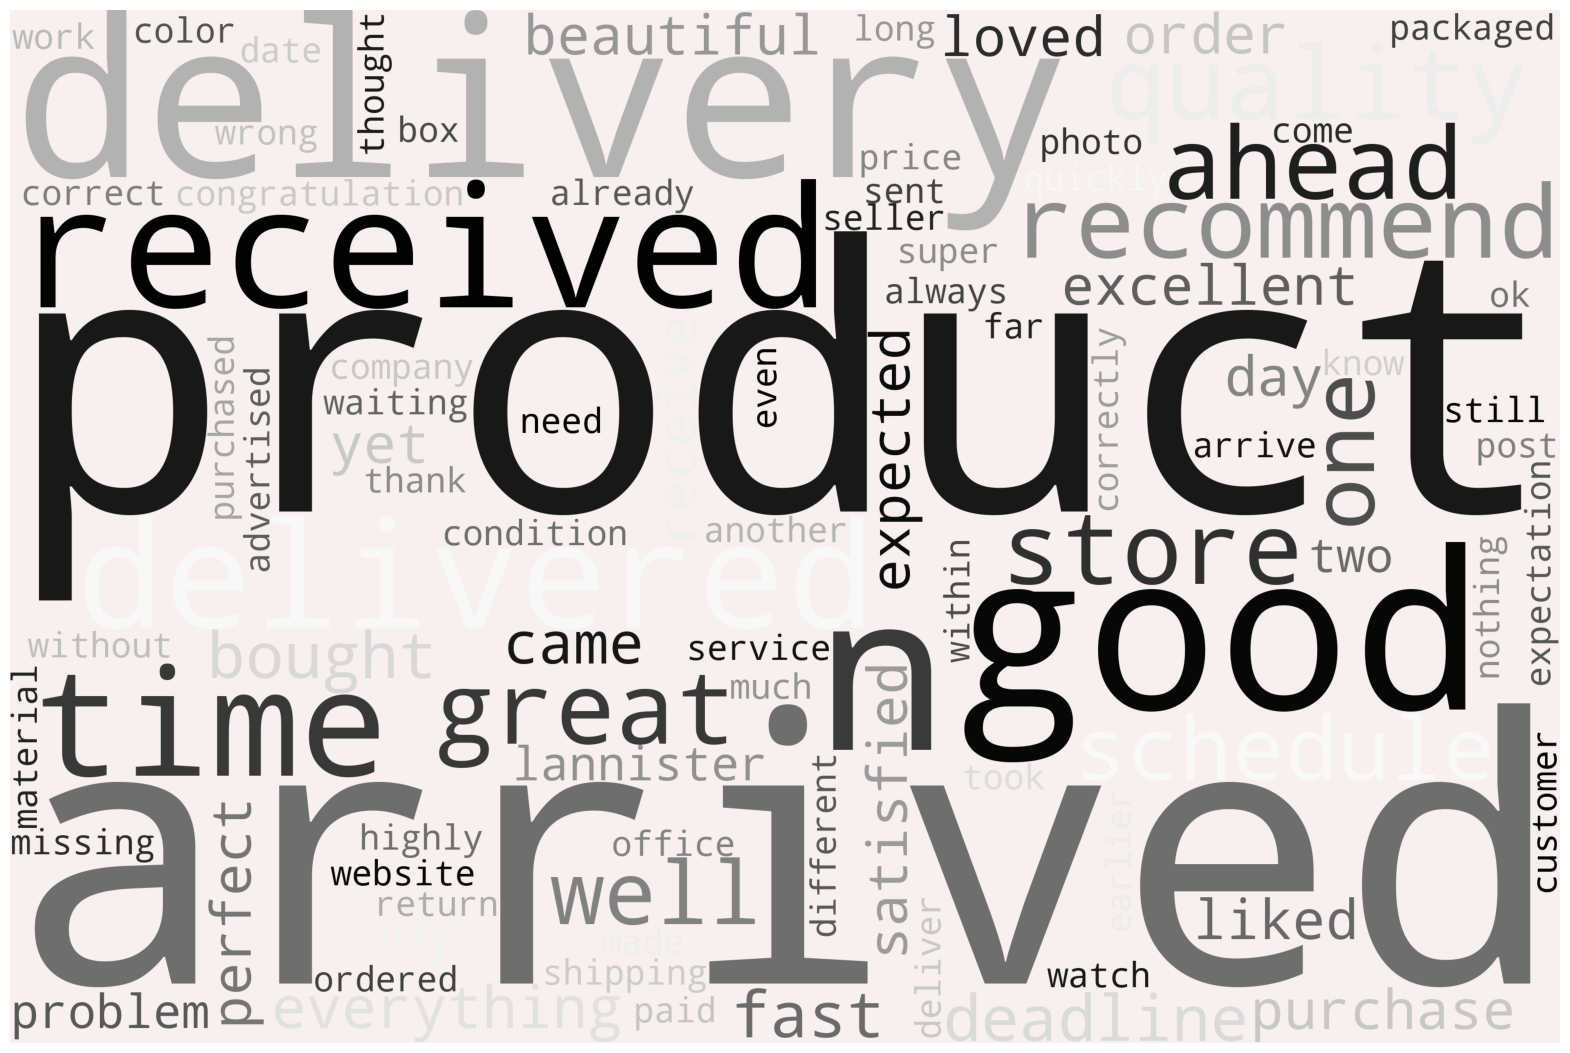

In [133]:
wordcloud = WordCloud(width=3000, height=2000, random_state=1,
                      background_color='#f7f0ee', colormap='binary_r',
                      collocations=False, stopwords=STOPWORDS).generate(' '.join(cloud))

plot_cloud(wordcloud)

In [75]:
# From https://www.geeksforgeeks.org/amazon-product-reviews-sentiment-analysis-in-python/
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

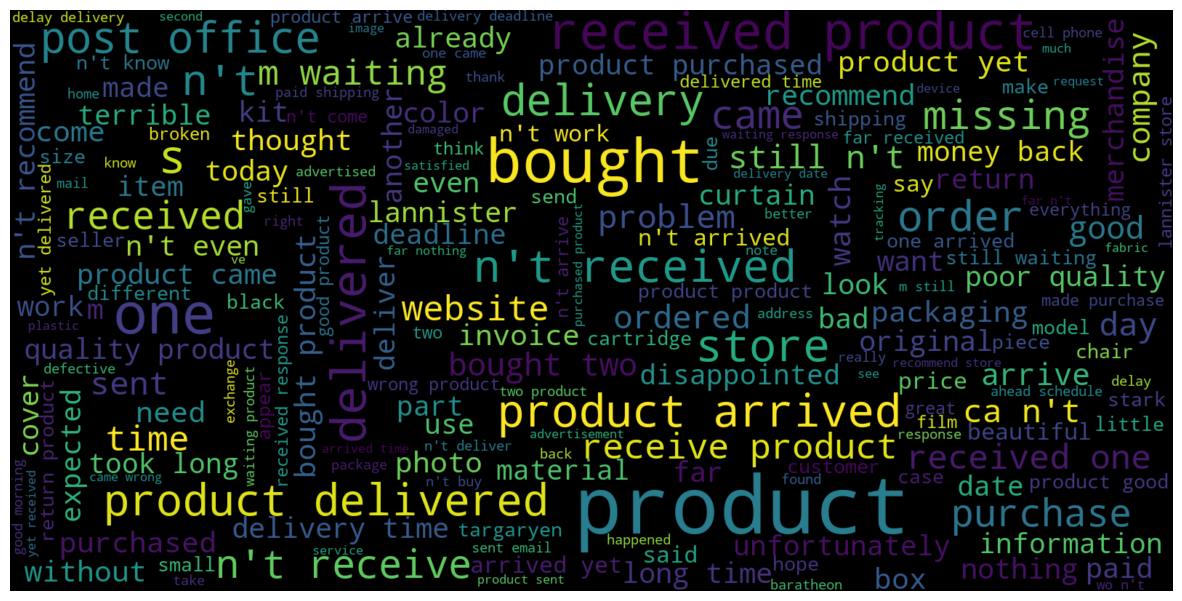

In [148]:
# Negative reviews

consolidated=' '.join(word for word in df_reviews['review_comment_message'][df_reviews["review_score"]==0].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

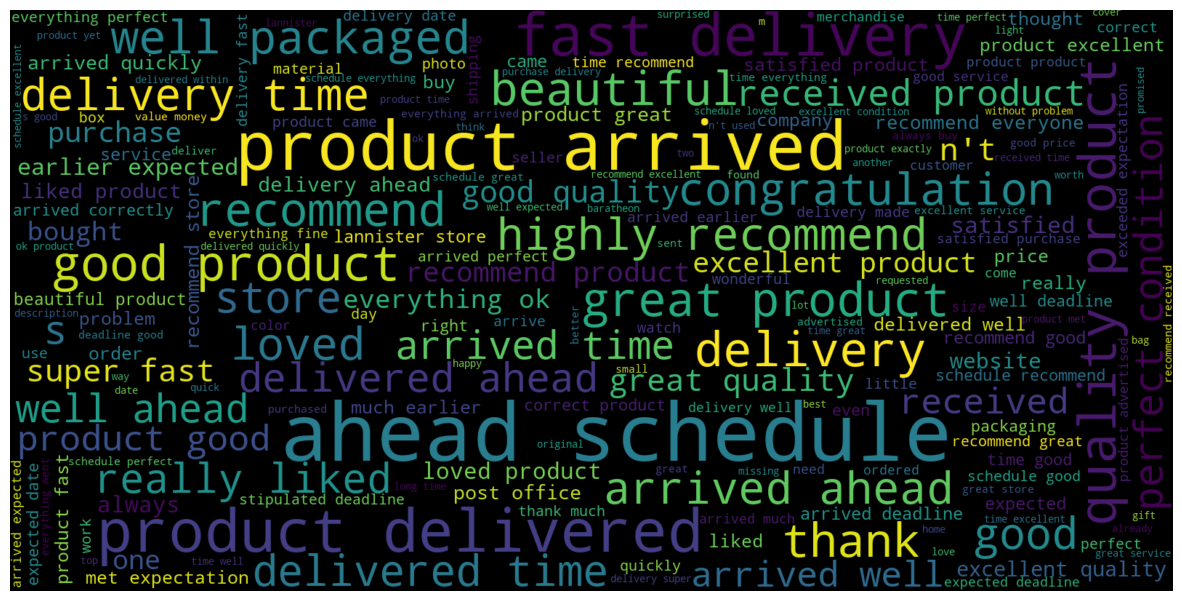

In [155]:
# Positive reviews

consolidated=' '.join(word for word in df_reviews['review_comment_message'][df_reviews["review_score"]==1].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

In [157]:
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(df_reviews['review_comment_message']).toarray()

In [159]:
from sklearn.model_selection import train_test_split
x_train ,x_test,y_train,y_test=train_test_split(X,df_reviews["review_score"],
												test_size=0.25 ,
												random_state=42)

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model=LogisticRegression()

#Model fitting
model.fit(x_train,y_train)

#testing the model
pred=model.predict(x_test)

#model accuracy
print(accuracy_score(y_test,pred))

0.8802416488983653


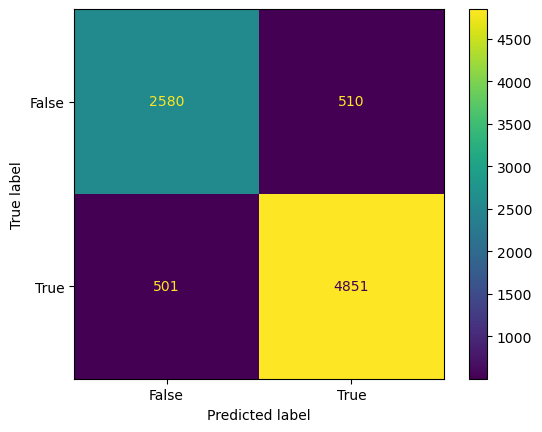

In [162]:
from sklearn import metrics
cm = confusion_matrix(y_test,pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
											display_labels = [False, True])

cm_display.plot()
plt.show()

In [165]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3090
           1       0.90      0.91      0.91      5352

    accuracy                           0.88      8442
   macro avg       0.87      0.87      0.87      8442
weighted avg       0.88      0.88      0.88      8442



Overall accuracy of this sentiment analysis model is 88%.

## Dataset EDA

In [167]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_approved_at"] = pd.to_datetime(df["order_approved_at"])
df["order_delivered_carrier_date"] = pd.to_datetime(df["order_delivered_carrier_date"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["shipping_limit_date"] = pd.to_datetime(df["shipping_limit_date"])

In [169]:
df["order_purchase_timestamp"].min()

Timestamp('2016-10-03 09:44:50')

In [171]:
df["order_purchase_timestamp"].max()

Timestamp('2018-08-29 15:00:37')

In [173]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,2017-08-19,2017-08-20 15:16:36,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,credit_card,3,37.77
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,2017-08-08,2017-08-08 23:26:23,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,credit_card,1,37.77


In [176]:
#Converts the column string to lowercase.And remove all punctuation marks, including those connected to words
df["review_comment_message"] = df["review_comment_message"].str.lower().str.replace('[{}]'.format(string.punctuation), '')

In [178]:
#How long it took for an order to change to approved after order was placed

df["time_to_approval"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.days
df["time_to_approval"].nlargest()

3501     30
47481    30
47482    30
47483    30
47484    30
Name: time_to_approval, dtype: int64

In [180]:
df["time_to_approval"].nsmallest()

0    0
1    0
2    0
3    0
4    0
Name: time_to_approval, dtype: int64

In [182]:
df[df.time_to_approval > 3].shape[0]

887

In [184]:
#How far was delivery date from the estimated delivery date

df["delivery_dif"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["delivery_dif"].nlargest()

103914    188
35319     181
113469    175
73248     167
43768     166
Name: delivery_dif, dtype: int64

In [190]:
#Doesn't make sense

df["delivery_dif"].nsmallest()

66675   -147
66676   -147
70051   -140
66690   -135
12289   -124
Name: delivery_dif, dtype: int64

In [192]:
df[df["delivery_dif"] >3].shape[0]

5301

In [194]:
#How far was shipment date from the requirments

df["shipment_dif"] = (df["order_delivered_carrier_date"] - df["shipping_limit_date"]).dt.days
df["shipment_dif"].nlargest()

69612    95
72828    91
54107    59
54108    59
45202    58
Name: shipment_dif, dtype: int64

In [196]:
# Doesn't make sense

df["shipment_dif"].nsmallest()

12289    -1047
12290    -1047
112402    -176
68042      -94
70051      -92
Name: shipment_dif, dtype: int64

In [198]:
df[df.shipment_dif > 3].shape[0]

2547

In [200]:
df.loc[66960]

order_id                                          ddc75e18227aa517946c2239d18d1300
customer_id                                       74fd1de60f458a07ceaded11a698fbc3
order_status                                                             delivered
order_purchase_timestamp                                       2018-07-27 21:30:56
order_approved_at                                              2018-07-27 22:15:12
order_delivered_carrier_date                                   2018-07-30 12:24:00
order_delivered_customer_date                                  2018-08-02 18:46:49
order_estimated_delivery_date                                  2018-08-15 00:00:00
order_item_id                                                                    1
product_id                                        698b3ddae2f0b80c2a48fb40624ca4e4
seller_id                                         0241d4d5d36f10f80c644447315af0bd
shipping_limit_date                                            2018-07-30 22:15:12
pric

In [202]:
filter = (df["time_to_approval"] > 3) | (df["delivery_dif"] > 3) | (df["shipment_dif"] > 3)
df_shipment_delivery = df[filter]

In [204]:
df_shipment_delivery.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,time_to_approval,delivery_dif,shipment_dif
59,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,1,be021417a6acb56b9b50d3fd2714baa8,...,19400,presidente venceslau,SP,1,credit_card,10,356.12,0,7,13
112,c49be9a11fd13933307cc6a19b03a895,a972623b3481cbfd95fa776b0067e554,delivered,2018-05-15 18:54:39,2018-05-17 03:16:13,2018-05-17 13:51:00,2018-06-06 13:27:44,2018-05-30,1,97f1396a5a1f7c07ba51784efdec44b8,...,36570,vicosa,MG,1,boleto,1,928.68,1,7,-4
113,c49be9a11fd13933307cc6a19b03a895,a972623b3481cbfd95fa776b0067e554,delivered,2018-05-15 18:54:39,2018-05-17 03:16:13,2018-05-17 13:51:00,2018-06-06 13:27:44,2018-05-30,2,97f1396a5a1f7c07ba51784efdec44b8,...,36570,vicosa,MG,1,boleto,1,928.68,1,7,-4
114,c49be9a11fd13933307cc6a19b03a895,a972623b3481cbfd95fa776b0067e554,delivered,2018-05-15 18:54:39,2018-05-17 03:16:13,2018-05-17 13:51:00,2018-06-06 13:27:44,2018-05-30,3,97f1396a5a1f7c07ba51784efdec44b8,...,36570,vicosa,MG,1,boleto,1,928.68,1,7,-4
115,c49be9a11fd13933307cc6a19b03a895,a972623b3481cbfd95fa776b0067e554,delivered,2018-05-15 18:54:39,2018-05-17 03:16:13,2018-05-17 13:51:00,2018-06-06 13:27:44,2018-05-30,4,97f1396a5a1f7c07ba51784efdec44b8,...,36570,vicosa,MG,1,boleto,1,928.68,1,7,-4


In [206]:
delay_in_approval = df_shipment_delivery.groupby("seller_id")["time_to_approval"].count().sort_values(ascending=False)
delay_in_approval

seller_id
4a3ca9315b744ce9f8e9374361493884    179
1025f0e2d44d7041d6cf58b6550e0bfa    148
7c67e1448b00f6e969d365cea6b010ab    143
1f50f920176fa81dab994f9023523100    142
88460e8ebdecbfecb5f9601833981930    130
                                   ... 
8e2b3afb420011ef0c88c9d5f11ea526      1
8e34331b7eedd03be4e5d965c1956225      1
8e4f041ff58e7845456d3482524014b3      1
8e670472e453ba34a379331513d6aab1      1
ffff564a4f9085cd26170f4732393726      1
Name: time_to_approval, Length: 1306, dtype: int64

In [208]:
#More relevant to shipping company than sellers

delay_in_delivery_to_user = df_shipment_delivery.loc[df_shipment_delivery["delivery_dif"]>3].groupby("seller_id")["delivery_dif"].count().sort_values(ascending=False)
delay_in_delivery_to_user

seller_id
4a3ca9315b744ce9f8e9374361493884    157
1f50f920176fa81dab994f9023523100    122
4869f7a5dfa277a7dca6462dcf3b52b2    104
7c67e1448b00f6e969d365cea6b010ab     81
955fee9216a65b617aa5c0531780ce60     73
                                   ... 
791cfcfe22fe4a771ece27f90017da92      1
afe0067131b73e40875c9b6c10bd2e21      1
79a679c36c08d606b3fd47ead9de109b      1
af7cdac9d9897cddead9c6b08976c642      1
7c4adcc13272c0e26fa23aac642adb7b      1
Name: delivery_dif, Length: 1064, dtype: int64

In [210]:

delay_in_delivery_to_comp = df_shipment_delivery.loc[df_shipment_delivery["shipment_dif"]>3].groupby("seller_id")["shipment_dif"].count().sort_values(ascending=False)
delay_in_delivery_to_comp

seller_id
88460e8ebdecbfecb5f9601833981930    123
1025f0e2d44d7041d6cf58b6550e0bfa     96
06a2c3af7b3aee5d69171b0e14f0ee87     67
7c67e1448b00f6e969d365cea6b010ab     65
8160255418d5aaa7dbdc9f4c64ebda44     62
                                   ... 
7c4618c82226628831613e95e9c22f44      1
7b7f91e98f8c6def45a1407923304402      1
7ad32824caee82087b3e2e5f33b1bf32      1
79ebd9a61bac3eaf882805ed4ecfa12a      1
ffff564a4f9085cd26170f4732393726      1
Name: shipment_dif, Length: 604, dtype: int64

In [212]:
df.loc[(df["time_to_approval"] > 3) & (df["shipment_dif"] > 3), "seller_rate"] = "bad"
df.loc[(df["time_to_approval"] > 3) | (df["shipment_dif"] > 3), "seller_rate"] = "needs improving"
df.loc[(df["time_to_approval"] < 1) & (df["shipment_dif"] < 1), "seller_rate"] = "excellent"
df.loc[(df["time_to_approval"] < 1) & (df["shipment_dif"] < 1), "seller_rate"] = "good"

In [214]:
df["seller_rate"] = df["seller_rate"].fillna("ok")

In [216]:
df["seller_rate"].value_counts()

seller_rate
good               89527
ok                 21107
needs improving     3417
Name: count, dtype: int64

In [218]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,time_to_approval,delivery_dif,shipment_dif,seller_rate
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,sao paulo,SP,1,credit_card,1,18.12,0,-8,-2,good
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,sao paulo,SP,3,voucher,1,2.00,0,-8,-2,good
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,sao paulo,SP,2,voucher,1,18.59,0,-8,-2,good
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,sao paulo,SP,1,credit_card,3,37.77,0,-10,-5,good
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,sao paulo,SP,1,credit_card,1,37.77,0,-8,-5,good


In [220]:
df_ts = df.set_index("order_purchase_timestamp")

In [222]:
df_ts['Year'] = df_ts.index.year
df_ts['Month'] = df_ts.index.month
df_ts['weekday_name'] = df_ts.index.day_name()

<Axes: xlabel='Month'>

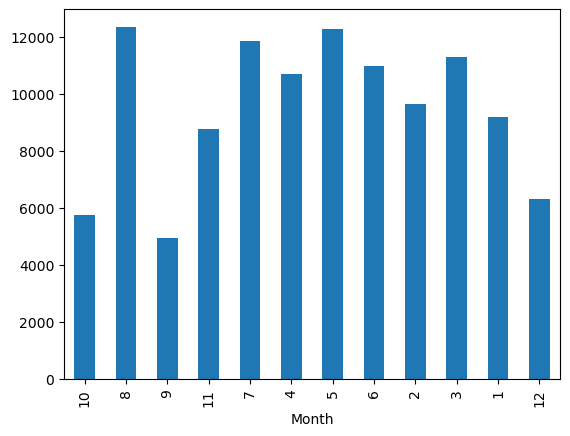

In [224]:
df_ts.Month.value_counts(sort=False).plot(kind='bar')

<Axes: xlabel='weekday_name'>

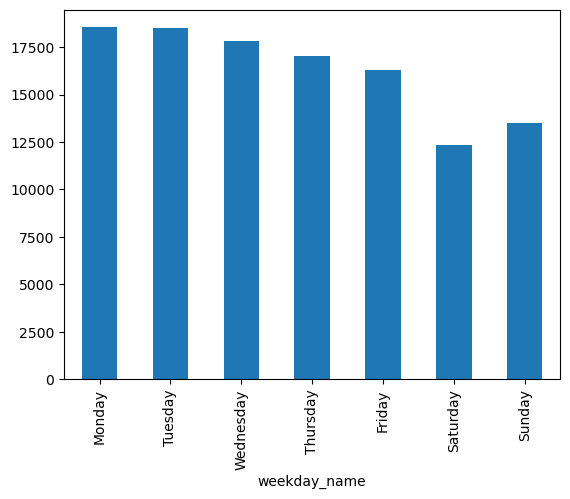

In [226]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_ts.weekday_name.value_counts(sort=False).loc[day_order].plot(kind='bar')

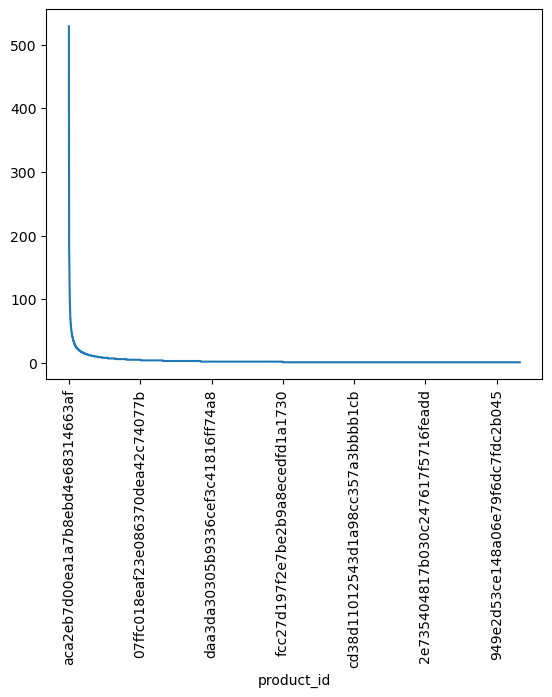

In [228]:
df_ts.product_id.value_counts().plot()
plt.xticks(rotation = 90)
plt.show()

<Axes: xlabel='order_purchase_timestamp'>

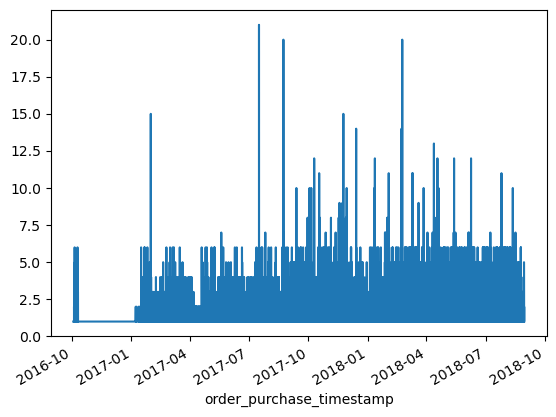

In [230]:
df_ts["order_item_id"].plot()

<Axes: xlabel='order_purchase_timestamp'>

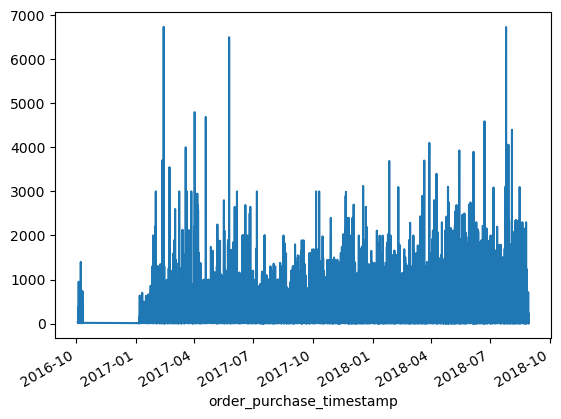

In [232]:
df_ts["price"].plot()